100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 453kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.13MB/s]


Using device: cuda
Epoch [1/20], Reconstruction Loss: 0.1944, Correlation Loss: 0.0021, Independence Loss: 1.1643, Adjacent Dependence Loss: 0.3945, Total Loss: 0.3524, HDS: 0.3187, HDSr: 0.4810, HDSc: 0.2624, HDSrc: 0.3982, Beta-VAE: 0.2192, Factor VAE: 0.3873, MIG: 0.1192, TC Proxy: 0.0791
Epoch [2/20], Reconstruction Loss: 0.1781, Correlation Loss: 0.0032, Independence Loss: 0.6288, Adjacent Dependence Loss: 0.2016, Total Loss: 0.2644, HDS: 0.6344, HDSr: 0.6969, HDSc: 0.4828, HDSrc: 0.5676, Beta-VAE: 0.1769, Factor VAE: 0.4206, MIG: 0.1302, TC Proxy: 0.0647
Epoch [3/20], Reconstruction Loss: 0.1576, Correlation Loss: 0.0030, Independence Loss: 0.5073, Adjacent Dependence Loss: 0.1532, Total Loss: 0.2267, HDS: 0.7073, HDSr: 0.7523, HDSc: 0.5503, HDSrc: 0.6233, Beta-VAE: 0.1962, Factor VAE: 0.4436, MIG: 0.1379, TC Proxy: 0.0936
Epoch [4/20], Reconstruction Loss: 0.1458, Correlation Loss: 0.0024, Independence Loss: 0.6469, Adjacent Dependence Loss: 0.1994, Total Loss: 0.2328, HDS: 0.62

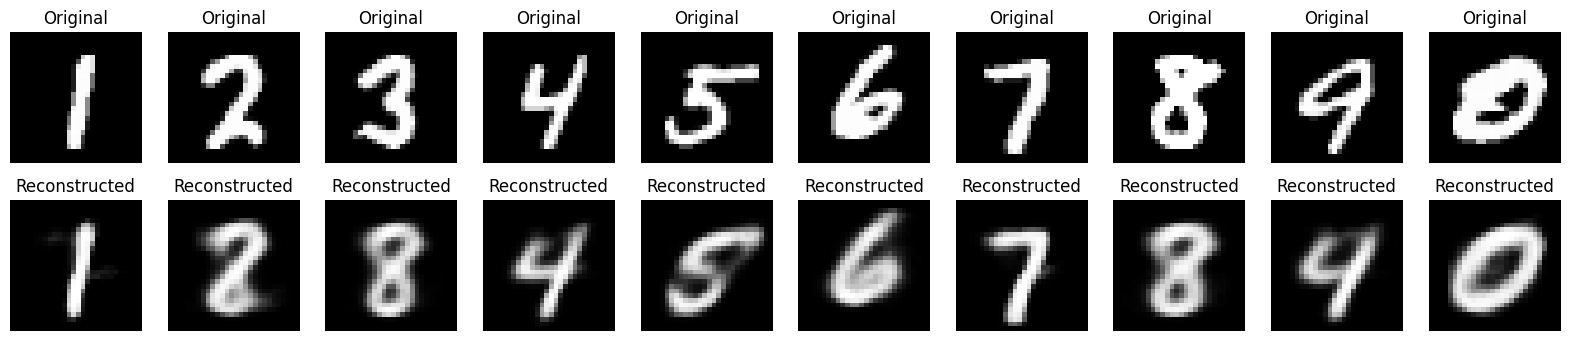

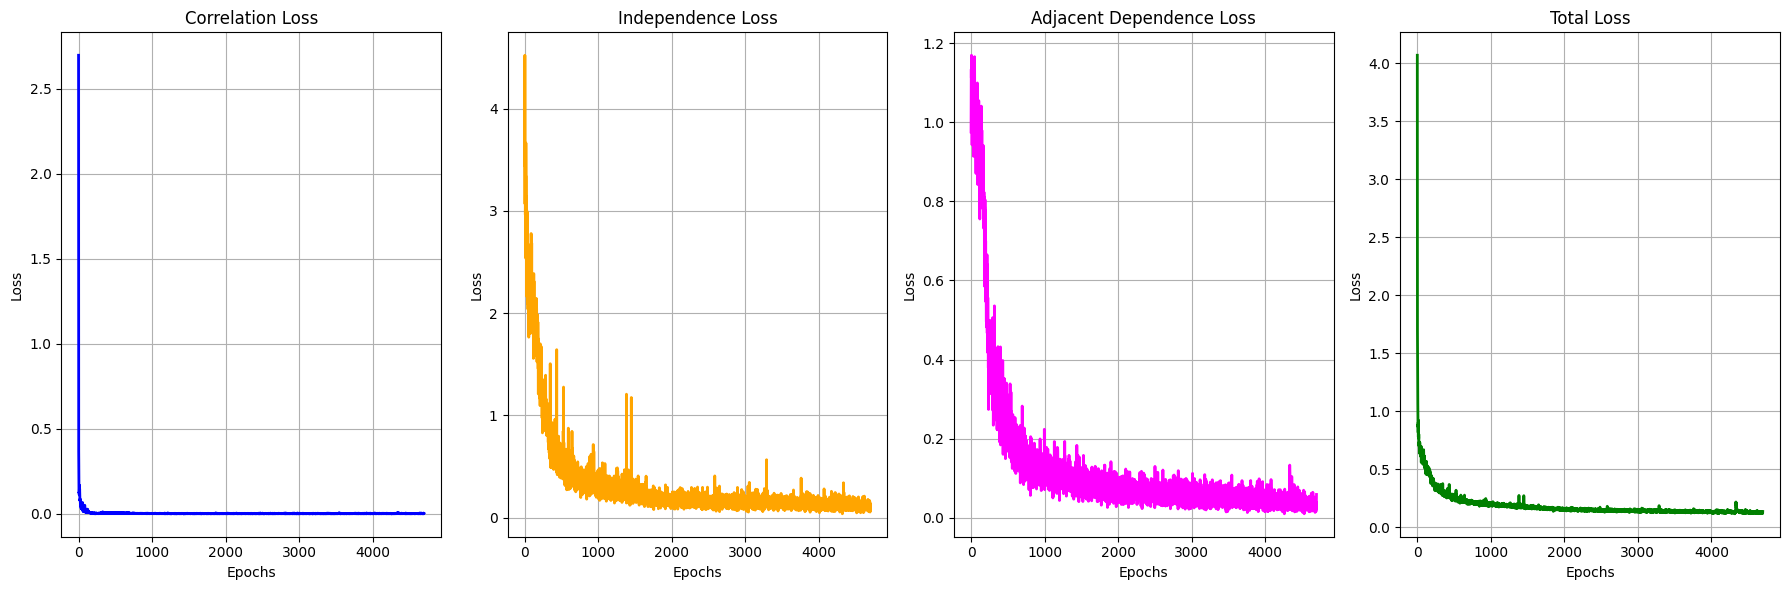

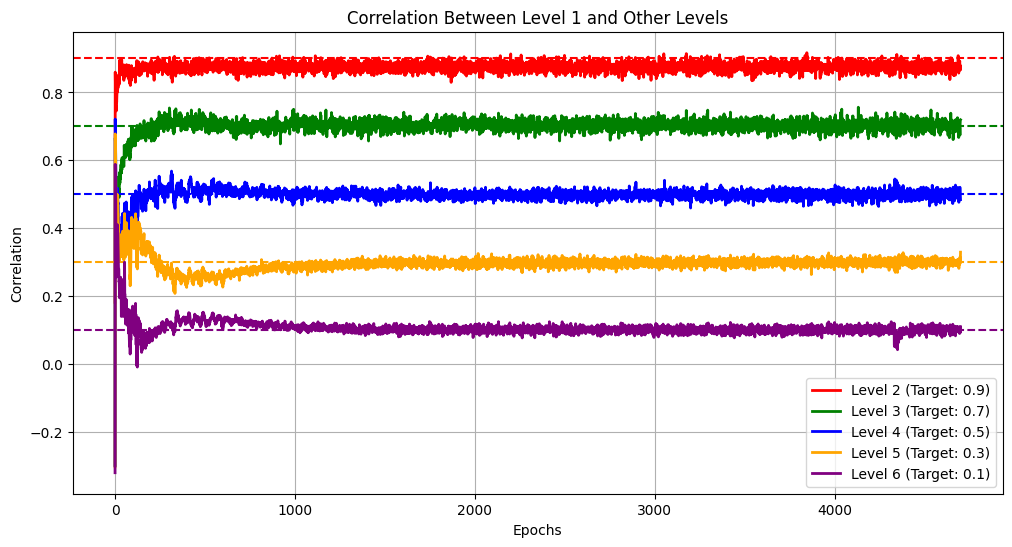

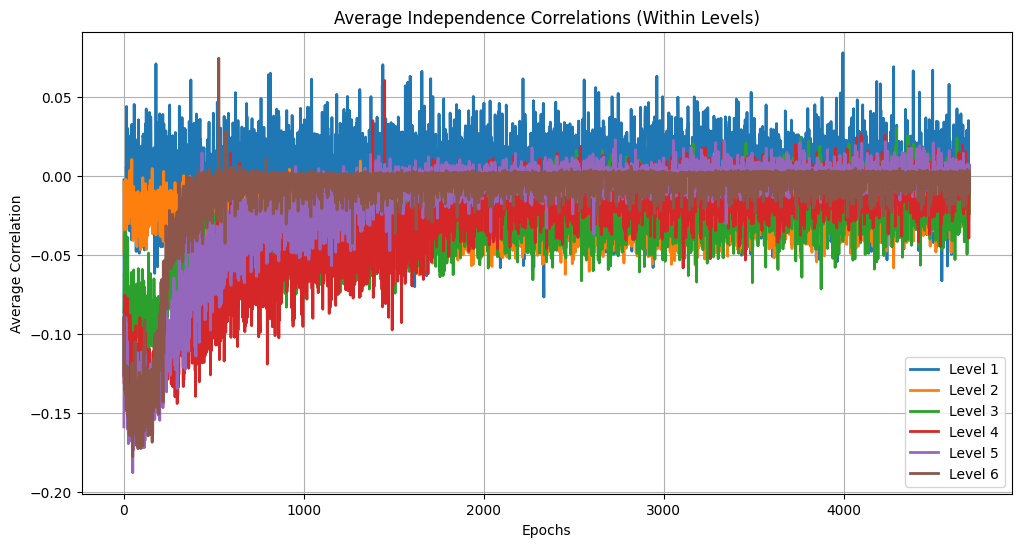

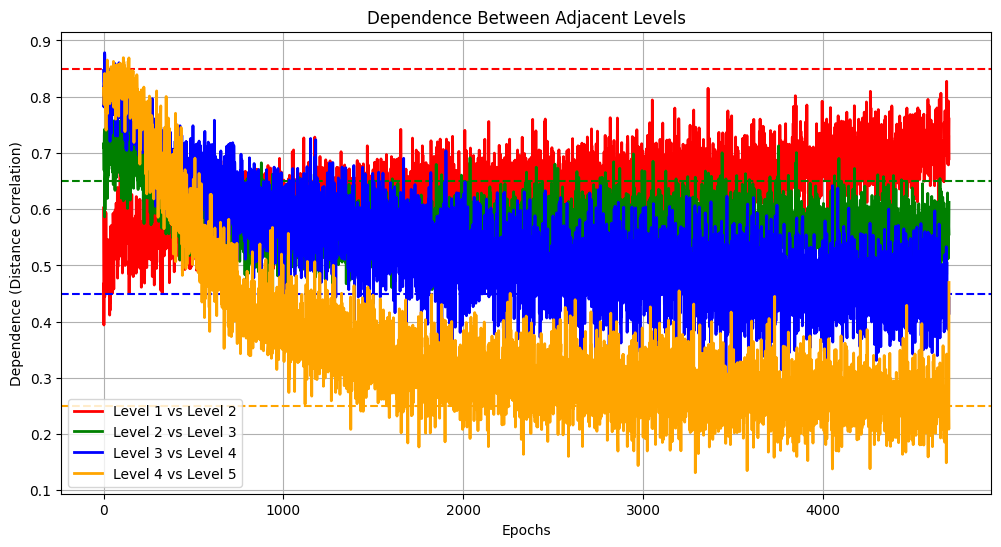

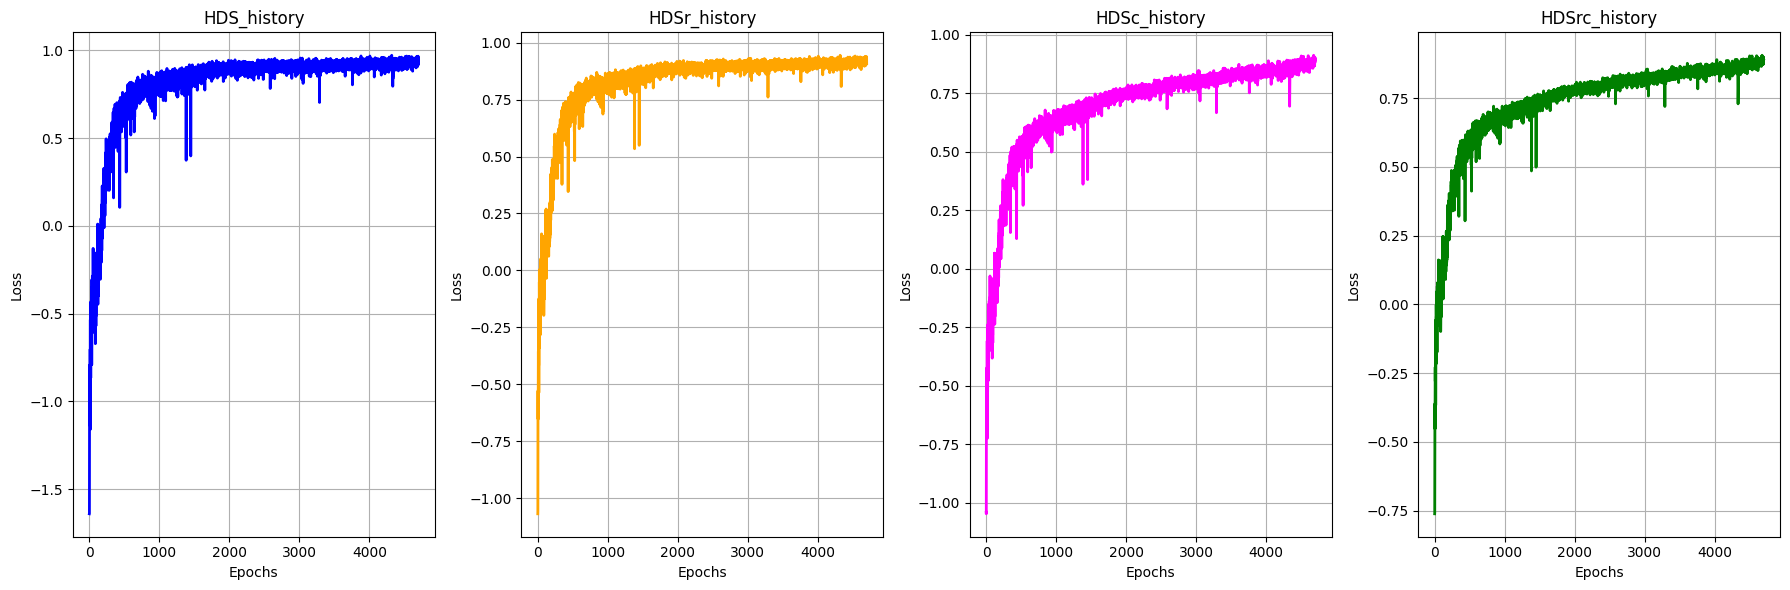

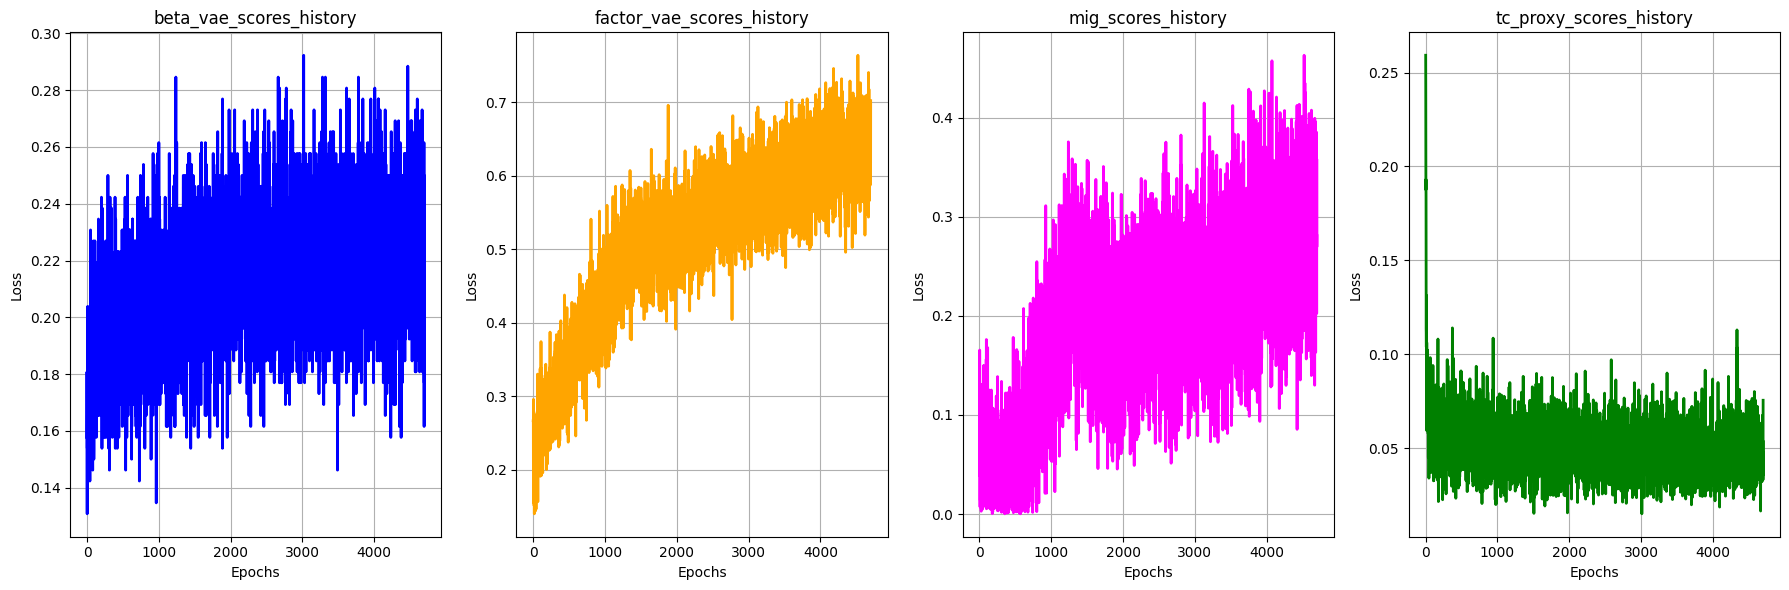

In [ ]:
# HDI-v10 - AE-enabeld ==> Using MNIST  + HDS Metric added + Disentanglement Metrics : Beta-VAE, FactorVAE, MIG, TC_proxy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score # For discrete MI estimation
############################################################ Target Values
#Define the target correlations
target_correlations = [0.9, 0.7, 0.5, 0.3, 0.1]

# Define target dependence values (adjust as needed)
target_dependence = [0.85, 0.65, 0.45, 0.25, 0.15]  # Example values

# Under the Gaussian distribution, the correlation coefficient and mutual information have a one-to-one mapping:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho ** 2)
    return result

def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

# Calculate target mutual information values from target correlations
target_MIs = []
for rho in target_correlations:
    mi = rho_to_mi(rho, dim=1)  # Assuming 1-dimensional features
    target_MIs.append(round(mi, 2))
############################################################# Dataset


# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

############################################################# CUDA Setup
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

######################################################################
# ############################################################# Losses
# Define the correlation loss
def correlation_loss(tensor, target_correlations):
    level_1 = tensor[0]  # Level 1
    # print('tensor shape = ', tensor.shape)
    loss = 0.0
    correlations = []
    for i, target_corr in enumerate(target_correlations):
        # print('i= ',i, 'target_corr= ',target_corr )
        level_i = tensor[i + 1]  # Other levels
        level_1_flat = level_1.flatten(start_dim=0, end_dim=1)
        level_i_flat = level_i.flatten(start_dim=0, end_dim=1)
        # print('level_1_flat  shape= ',level_1_flat.shape)
        # print('level_i_flat  shape= ',level_i_flat.shape)

        # Compute Pearson correlation
        cov = torch.mean((level_1_flat - level_1_flat.mean()) * (level_i_flat - level_i_flat.mean()))
        std_1 = level_1_flat.std()
        std_i = level_i_flat.std()
        corr = cov / (std_1 * std_i + 1e-8)
        correlations.append(corr.item())  # Store correlation
        loss += (corr - target_corr) ** 2

    return loss, correlations

# Define the independence loss
def independence_loss(tensor):
    loss = 0.0
    levels, batch_size, features = tensor.shape
    avg_correlations = []
    for level in tensor:
        level_corrs = []
        for i in range(features):
            for j in range(i + 1, features):
                col_i = level[:, i]
                col_j = level[:, j]
                cov = torch.mean((col_i - col_i.mean()) * (col_j - col_j.mean()))
                std_i = col_i.std()
                std_j = col_j.std()
                corr = cov / (std_i * std_j + 1e-8)
                level_corrs.append(corr.item())  # Store correlation
                loss += corr ** 2  # Penalize non-zero correlations
        avg_correlations.append(sum(level_corrs) / len(level_corrs))  # Average correlation for this level
    return loss, avg_correlations

# Define the mutual information loss
def mutual_information_loss(tensor, target_MIs):
    level_1 = tensor[0].detach().cpu().numpy()  # Level 1
    loss = 0.0
    mutual_infos = []
    lambda_reg = 0.01  # Regularization parameter

    for i, target_corr in enumerate(target_MIs):
        level_i = tensor[i + 1].detach().cpu().numpy()  # Other levels

        # Flatten the tensors for mutual information calculation
        level_1_flat = level_1.reshape(-1)
        level_i_flat = level_i.reshape(-1)

        # Compute mutual information using sklearn
        mi = mutual_info_regression(level_1_flat.reshape(-1, 1), level_i_flat, random_state=42)
        mi_value = mi[0] / np.log(2)  # Normalize MI to the range [0, 1]

        mutual_infos.append(mi_value)  # Store normalized mutual information
        weight = 1.0 if mi_value < target_corr else 0.5  # Dynamic weighting
        loss += weight * (mi_value - target_corr) ** 2  # Penalize deviation from target

    # Add regularization
    loss += lambda_reg * np.sum(np.square(mutual_infos))  # L2 regularization

    return loss, mutual_infos

# Define the distance correlation function
def distance_correlation(x, y):
    x = x - x.mean()
    y = y - y.mean()

    # Compute pairwise distances
    a = torch.cdist(x.unsqueeze(0), x.unsqueeze(0), p=2).squeeze()
    b = torch.cdist(y.unsqueeze(0), y.unsqueeze(0), p=2).squeeze()

    # Double centering
    A = a - a.mean(dim=0) - a.mean(dim=1).unsqueeze(1) + a.mean()
    B = b - b.mean(dim=0) - b.mean(dim=1).unsqueeze(1) + b.mean()

    # Compute distance covariance, variance, and correlation
    dcov = torch.sqrt((A * B).mean())
    dvar_x = torch.sqrt((A * A).mean())
    dvar_y = torch.sqrt((B * B).mean())

    return dcov / (torch.sqrt(dvar_x * dvar_y) + 1e-8)

# Define the adjacent level dependence loss
def adjacent_level_dependence_loss(tensor, target_dependence):
    levels, batch_size, features = tensor.shape
    loss = 0.0
    dependence_values = []

    for i in range(levels-1 ):
        # print('\n i= ',i)
        level_i = tensor[i].reshape(-1, features)
        level_next = tensor[i + 1].reshape(-1, features)

        dcorr = distance_correlation(level_i, level_next)
        dependence_values.append(dcorr.item())
        # print('dependence_values= ',dependence_values)

        # Compare to target dependence
        if i < len(target_dependence):  # Ensure we have a target value
            loss += (dcorr - target_dependence[i])**2
    return loss, dependence_values
########################################################################## Models
# Define the hierarchical bottleneck model
class HDI_model(nn.Module):
    def __init__(self, levels, features, dropout_rate=0.1, activation=nn.ReLU):
        """
        Enriched Correlation Model for Hierarchical Disentangled Information (HDI).

        Args:
            levels (int): Number of hierarchical levels.
            features (int): Number of features per level.
            dropout_rate (float): Dropout rate for regularization.
            activation (nn.Module): Activation function to use (default: ReLU).
        """
        super(HDI_model, self).__init__()
        self.levels = levels
        self.features = features
        self.activation = activation()

        # Define linear layers for each level (except the first one)
        self.linear_layers = nn.ModuleList([
            nn.Linear(features, features) for _ in range(levels - 1)
        ])

        # Define normalization layers for each level
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(features) for _ in range(levels - 1)
        ])

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_output):
        """
        Forward pass through the hierarchical model.
        Args:
            encoder_output (torch.Tensor): Input tensor from the encoder (shape: [batch_size, features]).
        Returns:
            torch.Tensor: Stacked tensor of hierarchical levels (shape: [levels, batch_size, features]).
        """
        levels = [encoder_output]  # First level is the encoder output
        for i, (layer, norm) in enumerate(zip(self.linear_layers, self.norm_layers)):
            # Linear transformation
            transformed = layer(levels[-1])
            # Add residual connection
            residual = transformed + levels[-1]
            # Apply normalization
            normalized = norm(residual)
            # Apply activation function
            activated = self.activation(normalized)
            # Apply dropout
            dropped_out = self.dropout(activated)
            # Append to levels
            levels.append(dropped_out)
        #print('mrh= ',torch.stack(levels).shape) # (levels, batch_size, BN_dim)
        # Stack levels into a tensor
        return torch.stack(levels)


class SimpleHDI(nn.Module):
    def __init__(self, levels, features):
        """
        Simple bottleneck that repeats the same level across all levels.
        Args:
            levels (int): Number of hierarchical levels.
            features (int): Number of features per level.
        """
        super(SimpleHDI, self).__init__()
        self.levels = levels
        self.features = features

    def forward(self, x):
        """
        Forward pass through the simple bottleneck.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, features).
        Returns:
            torch.Tensor: Bottleneck tensor of shape (levels, batch_size, features),
                          where all levels are identical.
        """
        # Repeat the input tensor across the levels dimension
        return x.unsqueeze(0).repeat(self.levels, 1, 1)



import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder2(nn.Module):
    def __init__(self, input_dim, hidden_dim, BN_dim, levels):
        super(Autoencoder2, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], BN_dim)  # Output is (batch_size, BN_dim)
        )

        # Bottleneck (HDI layer)
        # self.bottleneck = SimpleHDI(levels, BN_dim)  # or HDI2(levels, BN_dim)
        self.bottleneck = HDI_model(levels, BN_dim)  # or HDI2(levels, BN_dim)

        # Attention mechanism to extract one (batch_size, BN_dim) from (levels, batch_size, BN_dim)
        self.attention = nn.Sequential(
            nn.Linear(BN_dim, 1),  # Compute attention score for each level
            nn.Softmax(dim=0)      # Normalize scores across levels
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(BN_dim, hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], input_dim),
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def forward(self, x, method="attention", fixed_level=0, manual_weights=None):
        """
        Forward pass with a flag to choose the method for extracting (batch_size, BN_dim).

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            method (str): Method to extract (batch_size, BN_dim) from (levels, batch_size, BN_dim).
                          Options: "attention", "fixed", "weighted".
            fixed_level (int): Index of the level to select if method="fixed".
            manual_weights (torch.Tensor): Tensor of shape (levels,) containing weights for levels if method="weighted".

        Returns:
            torch.Tensor: Reconstructed input of shape (batch_size, input_dim).
        """
        # Encode input
        z = self.encoder(x)  # Shape: (batch_size, BN_dim)

        # Pass through HDI bottleneck
        HDI_levels = self.bottleneck(z)  # Shape: (levels, batch_size, BN_dim)

        if method == "attention":
            # Compute attention scores
            attention_scores = self.attention(HDI_levels)  # Shape: (levels, batch_size, 1)
            attention_scores = attention_scores.squeeze(-1)  # Shape: (levels, batch_size)

            # Weighted sum of levels using attention scores
            attention_scores = attention_scores.unsqueeze(-1)  # Shape: (levels, batch_size, 1)
            weighted_output = (HDI_levels * attention_scores).sum(dim=0)  # Shape: (batch_size, BN_dim)

        elif method == "fixed":
            # Select a specific level (e.g., first or last)
            weighted_output = HDI_levels[fixed_level]  # Shape: (batch_size, BN_dim)

        elif method == "weighted":
            # Use manually provided weights to compute a weighted sum
            if manual_weights is None:
                raise ValueError("manual_weights must be provided when method='weighted'")
            if manual_weights.shape[0] != HDI_levels.shape[0]:
                raise ValueError("manual_weights must have the same length as the number of levels")

            # Normalize weights to sum to 1
            manual_weights = manual_weights / manual_weights.sum()  # Shape: (levels,)
            manual_weights = manual_weights.unsqueeze(-1).unsqueeze(-1)  # Shape: (levels, 1, 1)

            # Weighted sum of levels
            weighted_output = (HDI_levels * manual_weights).sum(dim=0)  # Shape: (batch_size, BN_dim)

        else:
            raise ValueError(f"Invalid method: {method}. Choose from 'attention', 'fixed', or 'weighted'.")

        # Decode the weighted output
        x_reconstructed = self.decoder(weighted_output)  # Shape: (batch_size, input_dim)
        return x_reconstructed, HDI_levels
############################################################################### Configuration
# Hyperparameters
input_dim=28*28
hidden_dim=[256, 128]
levels = 6
BN_dim = 5 # Bottleneck features dim
learning_rate = 1e-3
num_epochs = 20  # Reduced for demonstration

################################################################## Initialization
# Initialize model, loss, and optimizer



# model = Autoencoder(input_dim, hidden_dim, BN_dim).to(device)
model= Autoencoder2(input_dim, hidden_dim, BN_dim, levels).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

############################################ Metric ##################

# Define normalization bounds for PSNR and SSIM
PSNR_min, PSNR_max = 0, 100  # Example values, adjust as needed
SSIM_min, SSIM_max = 0, 1     # Example values, adjust as needed

def compute_normalized_metric(independence_loss, corr_loss, adj_loss, reconstruction_loss, C=1, D=1, PSNR=None, SSIM=None):
    # Calculate Mean Hierarchical Loss
    mean_hierarchical_loss = (corr_loss + adj_loss) / 2

    # Normalize losses to [0, 1]
    normalized_independence_loss = 1 - independence_loss
    normalized_mean_hierarchical_loss = 1 - mean_hierarchical_loss
    normalized_reconstruction_loss = 1 - reconstruction_loss

    # Normalize PSNR or SSIM if provided
    normalized_PSRN = (PSNR - PSNR_min) / (PSNR_max - PSNR_min) if PSNR else 0
    normalized_SSIM = (SSIM - SSIM_min) / (SSIM_max - SSIM_min) if SSIM else 0

    # Compute the overall metric using Reconstruction Loss

    HDS = (normalized_independence_loss + C * normalized_mean_hierarchical_loss ) / (1 + C )
    HDSr = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_reconstruction_loss) / (1 + C + D)

    # Compute the overall metric using PSNR
    metric_PSRN = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_PSRN) / (1 + C + D)

    # Compute the overall metric using SSIM
    metric_SSIM = (normalized_independence_loss + C * normalized_mean_hierarchical_loss + D * normalized_SSIM) / (1 + C + D)

    HDSrc=0

    return HDS, HDSr,HDSrc # metric_PSRN, metric_SSIM


####
import torch

class HierarchicalMetric:
    def __init__(self, D=1, H=1, R=1, C=1):
        self.D = D
        self.H = H
        self.R = R
        self.C = C

    def compute_variability(self, HDI_levels):
        """
        Compute the variability from hierarchical disentangled levels.

        Args:
            HDI_levels (list of tensors): A list or tensor of bottleneck representations across M levels.

        Returns:
            float: The mean variance across levels.
        """
        variances = [torch.var(level, dim=0, unbiased=False).mean() for level in HDI_levels]
        mean_variability = torch.mean(torch.stack(variances))  # Mean variance across levels
        return mean_variability

    def compute_reconstruction_completeness(self, reconstruction_loss, R_max):
        """
        Compute completeness based on the normalized reconstruction loss.

        Args:
            reconstruction_loss (float): The reconstruction loss.
            R_max (float): The maximum possible reconstruction loss.

        Returns:
            float: Normalized completeness value.
        """
        if R_max > 0:
            return 1 - (reconstruction_loss / R_max)
        return 0

    def compute_normalized_metric(self, independence_loss, corr_loss, adj_loss,
                                   reconstruction_loss=None, HDI_levels=None, R_max=None):
        """
        Compute the normalized metric including various completeness measures.

        Args:
            independence_loss (float): The independence loss from the model.
            corr_loss (float): The correlation loss from the model.
            adj_loss (float): The adjacency loss from the model.
            reconstruction_loss (float, optional): The reconstruction loss from the model.
            HDI_levels (list of tensors, optional): The bottleneck representations.
            R_max (float, optional): Maximum possible reconstruction loss for completeness calculation.

        Returns:
            float: The overall computed metric.
        """

        # Mean Hierarchical Loss
        mean_hierarchical_loss = (corr_loss + adj_loss) / 2

        # Normalize losses to [0, 1]
        normalized_independence_loss = 1 - independence_loss
        normalized_mean_hierarchical_loss = 1 - mean_hierarchical_loss
        normalized_reconstruction_loss = 1 - reconstruction_loss if reconstruction_loss is not None else 0

        # Compute Completeness: either based on variability or reconstruction loss
        completeness_value = 0
        if HDI_levels is not None:
            # Option 1: Completeness based on variability
            variability = self.compute_variability(HDI_levels)
            completeness_value = variability.item()  # Mean variability as completeness
            # You could also incorporate other completeness methods based on your requirements:
            # completeness_value = self.compute_reconstruction_completeness(reconstruction_loss, R_max)

        # Compute the overall metric
        HDS   = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss ) / (self.D + self.H )
        HDSr  = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.R * normalized_reconstruction_loss) / (self.D + self.H + self.R)
        HDSc  = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.C * completeness_value) / (self.D + self.H + self.C)
        HDSrc = (self.D * normalized_independence_loss + self.H * normalized_mean_hierarchical_loss + self.R * normalized_reconstruction_loss + self.C * completeness_value) / (self.D + self.H + self.R + self.C)


        return HDS, HDSr, HDSc, HDSrc
######################################################################
def estimate_discrete_mi(x, y):
    """
    Estimates the discrete mutual information between two discrete variables.

    Args:
        x (np.ndarray): First discrete variable (must be 1D array).
        y (np.ndarray): Second discrete variable (must be 1D array).

    Returns:
        float: Estimated mutual information score.
    """
    # Ensure inputs are 1D arrays
    return mutual_info_score(x.flatten(), y.flatten())
def beta_vae_metric(latent_codes, ground_truth_labels): # Removed latent_dim arg, derived from latent_codes
    latent_dim = latent_codes.shape[1]
    scores = []
    for i in range(latent_dim):
        X = latent_codes[:, i].reshape(-1, 1)
        #print('X shape= ',X.shape)
        #print('X len= ',len(X))
        y = ground_truth_labels
        #print('Y shape= ',y.shape)
        #print('len(np.unique(y))= ',len(np.unique(y)))
        # Ensure enough samples for split and unique classes
        if len(X) < 100 or len(np.unique(y)) < 2: # Added a minimum sample check
             # print(f"Skipping latent dim {i} due to insufficient data or classes.")
             scores.append(0.0)
            #  print('@')
             continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None)

        # Check again after split
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
             # print(f"Skipping latent dim {i} due to insufficient classes after split.")
             scores.append(0.0)
            #  print('@@')
             continue

        try:
            classifier = LogisticRegression(solver='liblinear', random_state=42) # Removed multi_class='auto'
            classifier.fit(X_train, y_train)
            score = classifier.score(X_test, y_test)
            scores.append(score)
            #print('MRH score= ',score)

        except Exception as e:
            # print(f"Warning: Could not train classifier for latent dim {i}: {e}")
            scores.append(0.0)
            # print('@@@')
    # Handle case where no scores were added
    return np.mean(scores) if scores else 0.0


def factor_vae_metric(latent_codes, ground_truth_labels): # Removed latent_dim arg
    latent_dim = latent_codes.shape[1]
    num_bins = 10
    # Ensure enough samples for binning
    if len(latent_codes) == 0:
        return 0.0
    # Calculate bins based on the range of the entire latent space
    global_min = latent_codes.min()
    global_max = latent_codes.max()
    if global_max == global_min: # Avoid division by zero or constant values
         binned_latent_codes = np.zeros_like(latent_codes, dtype=int)
    else:
         bins = np.linspace(global_min, global_max, num_bins + 1) # +1 for edges
         # Ensure all values fall within bins, clip extreme values
         binned_latent_codes = np.digitize(latent_codes, bins=bins)
         # Adjust bin indices to be 0-based
         binned_latent_codes[binned_latent_codes == num_bins + 1] = num_bins # Clip max values
         binned_latent_codes = binned_latent_codes - 1 # Make 0-indexed
         binned_latent_codes[binned_latent_codes < 0] = 0 # Clip min values


    mi_scores = []
    for i in range(latent_dim):
        # Check if there's enough variation in the binned dimension and labels
        if len(np.unique(binned_latent_codes[:, i])) > 1 and len(np.unique(ground_truth_labels)) > 1:
            try:
                 mi = estimate_discrete_mi(binned_latent_codes[:, i], ground_truth_labels)
                 mi_scores.append(mi)
            except ValueError as e:
                 # mutual_info_score can raise ValueError for insufficient unique labels
                 # print(f"Warning: Could not estimate MI for latent dim {i}: {e}")
                 mi_scores.append(0.0)
        else:
            mi_scores.append(0.0) # No variation means no mutual information

    return np.max(mi_scores) if mi_scores else 0.0 # Simplified for MNIST single factor

def mutual_information_gap(latent_codes, ground_truth_labels): # Removed latent_dim arg
    latent_dim = latent_codes.shape[1]
    num_bins = 10
    if len(latent_codes) == 0:
        return 0.0
    global_min = latent_codes.min()
    global_max = latent_codes.max()
    if global_max == global_min:
         binned_latent_codes = np.zeros_like(latent_codes, dtype=int)
    else:
         bins = np.linspace(global_min, global_max, num_bins + 1)
         binned_latent_codes = np.digitize(latent_codes, bins=bins)
         binned_latent_codes[binned_latent_codes == num_bins + 1] = num_bins
         binned_latent_codes = binned_latent_codes - 1
         binned_latent_codes[binned_latent_codes < 0] = 0

    mi_scores_per_latent_dim = []
    for i in range(latent_dim):
        if len(np.unique(binned_latent_codes[:, i])) > 1 and len(np.unique(ground_truth_labels)) > 1:
             try:
                  mi = estimate_discrete_mi(binned_latent_codes[:, i], ground_truth_labels)
                  mi_scores_per_latent_dim.append(mi)
             except ValueError:
                  mi_scores_per_latent_dim.append(0.0)
        else:
             mi_scores_per_latent_dim.append(0.0)

    sorted_mi = sorted(mi_scores_per_latent_dim, reverse=True)

    # Ensure there are at least two MI scores to calculate a gap
    if len(sorted_mi) >= 2:
        mig_for_factor = sorted_mi[0] - sorted_mi[1]
    else:
        mig_for_factor = 0 # Cannot calculate gap with less than 2 dimensions

    return mig_for_factor


def total_correlation_proxy(latent_codes):
    if latent_codes.shape[1] < 2 or len(latent_codes) < 2: # Need at least 2 samples for correlation
         return 0.0
    try:
         correlation_matrix = np.corrcoef(latent_codes.T)
         # Check if correlation matrix is valid (no NaNs or Infs)
         if not np.all(np.isfinite(correlation_matrix)):
              print("Warning: Non-finite values in correlation matrix. Returning 0.0 for TC proxy.")
              return 0.0

         off_diagonal_abs_sum = np.sum(np.abs(correlation_matrix - np.eye(correlation_matrix.shape[0])))
         num_off_diagonal = correlation_matrix.shape[0] * (correlation_matrix.shape[0] - 1)

         if num_off_diagonal > 0:
             return off_diagonal_abs_sum / num_off_diagonal
         else:
             return 0.0
    except Exception as e:
         print(f"Error calculating TC proxy: {e}")
         return 0.0




#######################################################################
# Track metrics for plotting
correlation_history = []  # To track correlations between levels
independence_history = []  # To track average independence correlations
mutual_information_history = []  # To track mutual information between levels
adjacent_dependence_history = []  # To track adjacent level dependence

# Initialize lists to track losses
corr_loss_history = []  # To track correlation loss
indep_loss_history = []  # To track independence loss
mi_loss_history = []
adj_loss_history=[]
total_loss_history = []  # To track total loss

HDS_history = []
HDSr_history = []
HDSc_history = []
HDSrc_history = []
#
beta_vae_scores_history=[]
factor_vae_scores_history=[]
mig_scores_history=[]
tc_proxy_scores_history=[]

model.train()

# Create an instance of HierarchicalMetric
metric_calculator = HierarchicalMetric(D=1, H=1, R=1, C=1)
previous_beta_vae_score=0
# Training the autoencoder
for epoch in range(num_epochs):
    # train_loss = train(model, train_loader, criterion, optimizer, device)

    train_loss = 0
    for images, targets in train_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)  # Flatten images

        ############################################### Forward pass
        # MRH: simple
        # output = model(images)

        # MRH: Attention
        output, HDI_levels = model(images, method="attention")
        #print('\nHDI_levels= ',HDI_levels)

        # print('HDI_levels type= ', type(HDI_levels))
        # print('HDI_levels shape= ', HDI_levels.shape)

        # raise Exception("Mohammad Reza Hasanabadi")

        # MRH: Fixed
        #output = model(images, method="fixed", fixed_level=3)  # Select the first level
        #print('\nimages shape= ',images.shape) # torch.Size([256, 784])
        #print('output shape= ',output.shape) # torch.Size([256, 784])

        # MRH: Weighted
        # manual_weights = torch.tensor([0.1, 0.2, 0.3, 0.4]).to(device)  # Example weights for 4 levels
        # output = model(images, method="weighted", manual_weights=manual_weights)

        ############################################# Compute the losses
        reconstruction_loss = criterion(output, images)
        corr_loss, correlations = correlation_loss(HDI_levels, target_correlations)
        indep_loss, avg_independence_corrs = independence_loss(HDI_levels)
        # mi_loss, mutual_infos = mutual_information_loss(HDI_levels target_MIs)
        adj_loss, dependence_values = adjacent_level_dependence_loss(HDI_levels, target_dependence)

        total_loss = reconstruction_loss + corr_loss + 0.1 * indep_loss  + 0.1 * adj_loss

        # Backward pass and optimization
        # total_loss.backward()




        # Backward pass
        optimizer.zero_grad()
        # loss.backward()
        total_loss.backward()
        optimizer.step()


        # Track Parameters
        correlation_history.append(correlations)
        independence_history.append(avg_independence_corrs)
        # mutual_information_history.append(mutual_infos)
        adjacent_dependence_history.append(dependence_values)


        # Track losses
        corr_loss_history.append(corr_loss.item())
        indep_loss_history.append(indep_loss.item())
        # mi_loss_history.append(mi_loss.item())
        adj_loss_history.append(adj_loss.item())
        total_loss_history.append(total_loss.item())

        # train_loss += loss.item()
        train_loss += total_loss.item()



        # Calculate metrics
        HDS, HDSr, HDSc, HDSrc = metric_calculator.compute_normalized_metric(
            indep_loss.item(),
            corr_loss.item(),
            adj_loss.item(),
            reconstruction_loss.item(),
            HDI_levels=HDI_levels
        )


        ##
        HDS_history.append(HDS)
        HDSr_history.append(HDSr)
        HDSc_history.append(HDSc)
        HDSrc_history.append(HDSrc)


        ###

        #############################################


                                        # #model.eval() # Set model to evaluation mode
        # latent_codes = []
        # labels = []
                                        # print("Extracting initial encoder output (z) from test set for metric calculation...")
                                        # with torch.no_grad():
                                        #     for images, targets in dataloader:
                                        #         images = images.to(device)
                                                # Get the initial encoder output 'z' directly from the encoder
                                                # We DO NOT use the full model.forward() here for metric extraction,
                                                # because the metrics apply to the *input* of the HDI layer.
        z = model.encoder(images)
        latent_code = z.detach().cpu().numpy()
        labels = targets.cpu().numpy()
                                        # return np.concatenate(latent_codes, axis=0), np.concatenate(labels, axis=0)
        ############################################
        latent_codes = HDI_levels[0]  # Use the last HDI level or average/concatenate as needed
        # print('z shape=  ', z.shape)
        # print('latent_codes shape = ',latent_codes.shape )


        #
        latent_dim = latent_codes.shape[1]
        scores = []
        # for i in range(latent_dim):
        #     X = latent_codes[:, i].reshape(-1, 1)
        #     print('X shape= ',X.shape)
        #     print('X len= ',len(X))
        #     print('np.unique(ground_truth_labels= ',np.unique(labels))

        # raise Exception("Sorry, Mohammad Reza Hasanabadi")
        # Calculate disentanglement metrics
        beta_vae_score = beta_vae_metric(latent_code, labels)
        factor_vae_score = factor_vae_metric(latent_code, labels)
        mig_score = mutual_information_gap(latent_code, labels)
        tc_proxy_score = total_correlation_proxy(latent_code)
        #print('beta_vae_score= ',beta_vae_score)

        #### MRH: Consideration for beta- VAE to avoid being zero at lat batch less than 256
        if beta_vae_score == 0.0 and previous_beta_vae_score != 0.0:
            beta_vae_score = previous_beta_vae_score
        previous_beta_vae_score = beta_vae_score # Update the previous score
        ####

        # Store the metrics collected in this epoch
        beta_vae_scores_history.append(beta_vae_score)
        factor_vae_scores_history.append(factor_vae_score)
        mig_scores_history.append(mig_score)
        tc_proxy_scores_history.append(tc_proxy_score)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Reconstruction Loss: {reconstruction_loss.item():.4f}, "
          f"Correlation Loss: {corr_loss.item():.4f}, Independence Loss: {indep_loss:.4f}, "
          f"Adjacent Dependence Loss: {adj_loss:.4f}, "
          f"Total Loss: {total_loss.item():.4f}, "
          f"HDS: {HDS:.4f}, HDSr: {HDSr:.4f}, HDSc: {HDSc:.4f}, HDSrc: {HDSrc:.4f}, "
          f"Beta-VAE: {beta_vae_score:.4f}, Factor VAE: {factor_vae_score:.4f}, "
          f"MIG: {mig_score:.4f}, TC Proxy: {tc_proxy_score:.4f}"
          )
    #raise Exception("Sorry, Mohammad Reza Hasanabadi")
    # print(f"Epoch [{epoch + 1}/{num_epochs}], "
    #       f"Reconstruction Loss: {reconstruction_loss.item():.4f}, "
    #       f"Correlation Loss: {corr_loss.item():.4f}, Independence Loss: {indep_loss:.4f}, "
    #       f"Adjacent Dependence Loss: {adj_loss:.4f}, "
    #       f"Total Loss: {total_loss.item():.4f},"
    #       f"HDS: {HDS:.4f}, "
    #       f"HDSr: {HDSr:.4f}, "
    #       f"HDSc: {HDSc:.4f},"
    #       f"HDSrc: {HDSrc:.4f}"
    #       )


##########
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images = images.view(images.size(0), -1)  # Flatten images
        outputs,_ = model(images)
images = images.view(-1, 28, 28).cpu().numpy()
outputs = outputs.view(-1, 28, 28).cpu().numpy()

# Plot original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    plt.subplot(2, n, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
            # return images, outputs  # Return a batch for visualization

####################################################
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
losses = [
    (corr_loss_history, "Correlation Loss", "blue"),
    (indep_loss_history, "Independence Loss", "orange"),
    (adj_loss_history, "Adjacent Dependence Loss", "magenta"),
    (total_loss_history, "Total Loss", "green"),
]

for i, (loss, title, color) in enumerate(losses):
    axs[i].plot(loss, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()

# Convert tracked metrics to tensors for easier plotting
correlation_history = torch.tensor(correlation_history)
independence_history = torch.tensor(independence_history)
# mutual_information_history = torch.tensor(mutual_information_history)
adjacent_dependence_history = torch.tensor(adjacent_dependence_history)

# Plot Correlations Between Levels
plt.figure(figsize=(12, 6))
colors = ['r', 'g', 'b', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.plot(correlation_history[:, i], label=f"Level {i + 2} (Target: {target_correlations[i]})", color=color, linewidth=2)
    plt.axhline(y=target_correlations[i], color=color, linestyle='--', linewidth=1.5)  # Target line
plt.title("Correlation Between Level 1 and Other Levels")
plt.xlabel("Epochs")
plt.ylabel("Correlation")
plt.legend()
plt.grid()
plt.show()

# Plot Average Independence Correlations Within Levels
plt.figure(figsize=(12, 6))
for i in range(levels):
    plt.plot(independence_history[:, i], label=f"Level {i + 1}", linewidth=2)
plt.title("Average Independence Correlations (Within Levels)")
plt.xlabel("Epochs")
plt.ylabel("Average Correlation")
plt.legend()
plt.grid()
plt.show()

# Plot Mutual Information Between Levels
# plt.figure(figsize=(12, 6))
# for i, color in enumerate(colors):
#     plt.plot(mutual_information_history[:, i], label=f"Level {i + 2} (Target: {target_MIs[i]})", color=color, linewidth=2)
#     plt.axhline(y=target_MIs[i], color=color, linestyle='--', linewidth=1.5)  # Target line
# plt.title("Mutual Information Between Level 1 and Other Levels")
# plt.xlabel("Epochs")
# plt.ylabel("MI")
# plt.legend()
# plt.grid()
# plt.show()

# Plot Dependence Between Adjacent Levels
plt.figure(figsize=(12, 6))
for i, color in enumerate(colors[:-1]):  # Only `levels - 1` adjacent levels
    dependence_by_level = [dependence[i] for dependence in adjacent_dependence_history]
    plt.plot(dependence_by_level, label=f"Level {i + 1} vs Level {i + 2}", color=color, linewidth=2)
    plt.axhline(y=target_dependence[i], color=color, linestyle='--', linewidth=1.5)  # Target line
plt.title("Dependence Between Adjacent Levels")
plt.xlabel("Epochs")
plt.ylabel("Dependence (Distance Correlation)")
plt.legend()
plt.grid()
plt.show()

#################################################### Metric
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
metrics = [
    (HDS_history, "HDS_history", "blue"),
    (HDSr_history, "HDSr_history", "orange"),
    (HDSc_history, "HDSc_history", "magenta"),
    (HDSrc_history, "HDSrc_history", "green"),
]

for i, (metric, title, color) in enumerate(metrics):
    axs[i].plot(metric, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()
#################################################################
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
metrics = [
    (beta_vae_scores_history, "beta_vae_scores_history", "blue"),
    (factor_vae_scores_history, "factor_vae_scores_history", "orange"),
    (mig_scores_history, "mig_scores_history", "magenta"),
    (tc_proxy_scores_history, "tc_proxy_scores_history", "green"),
]

for i, (metric, title, color) in enumerate(metrics):
    axs[i].plot(metric, color=color, linewidth=2)
    axs[i].set_title(title)
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].grid()

plt.tight_layout()
plt.show()
